## Sentiment Analysis

In [1]:
import pandas as pd
import nltk
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np


In [2]:
# Load your dataset
movies = pd.read_csv('../data/clean/movie_df.csv')

Explode columns

In [3]:
movies['events'] = movies['events'].str.split(',')  # Split by comma
movies['genres'] = movies['genres'].str.split(',')  # Split by comma

# Exploding both columns (this creates multiple rows for each combination of events and genres)
df = movies.explode('events').explode('genres').reset_index(drop=True)

# Show exploded DataFrame
print(df)

                   title  release_year    genres                     director  \
0      Bad Boys for Life          2020  thriller  Bilall Fallah, Adil El Arbi   
1      Bad Boys for Life          2020    action  Bilall Fallah, Adil El Arbi   
2      Bad Boys for Life          2020     crime  Bilall Fallah, Adil El Arbi   
3      Bad Boys for Life          2020  thriller  Bilall Fallah, Adil El Arbi   
4      Bad Boys for Life          2020    action  Bilall Fallah, Adil El Arbi   
...                  ...           ...       ...                          ...   
52600              Waves          2024     drama                    Jiří Mádl   
52601              Waves          2024   history                    Jiří Mádl   
52602              Waves          2024  thriller                    Jiří Mádl   
52603              Waves          2024     drama                    Jiří Mádl   
52604              Waves          2024   history                    Jiří Mádl   

       runtime language    

## Sentiment Analysis on Events
Sentiment polarity ranges from -1 (negative sentiment) to +1 (positive sentiment). We can calculate the average sentiment per movie by aggregating the sentiments of its individual events.

In [4]:
# Function to calculate sentiment of each event
def get_event_sentiment(event):
    # Create a TextBlob object for the event
    blob = TextBlob(event)
    # Return the polarity score of the event (range is -1 to 1)
    return blob.sentiment.polarity

# Apply the sentiment function to the 'events' column
df['event_sentiment'] = df['events'].apply(get_event_sentiment)

# Check the DataFrame to confirm the sentiment analysis results
print(df[['title', 'events', 'event_sentiment']])


                   title                     events  event_sentiment
0      Bad Boys for Life  flashing lights or images              0.0
1      Bad Boys for Life  flashing lights or images              0.0
2      Bad Boys for Life  flashing lights or images              0.0
3      Bad Boys for Life         shaving or cutting             -0.6
4      Bad Boys for Life         shaving or cutting             -0.6
...                  ...                        ...              ...
52600              Waves                  meltdowns              0.0
52601              Waves                  meltdowns              0.0
52602              Waves                  screaming              0.0
52603              Waves                  screaming              0.0
52604              Waves                  screaming              0.0

[52605 rows x 3 columns]


## Overall Sentiment for Each Movie
Group by the movie's title and average the sentiment of the events related to that movie. Since the dataset has exploded rows, you can group the DataFrame by the title column.

In [5]:
# Group by 'title' and calculate the average sentiment for each movie
movie_sentiments = df.groupby('title')['event_sentiment'].mean().reset_index()

# Check the sentiment scores for each movie
print(movie_sentiments)


                       title  event_sentiment
0                       1917        -0.038050
1     20,000 Species of Bees        -0.080952
2                 21 Bridges        -0.100000
3                3 from Hell        -0.034271
4    47 Meters Down: Uncaged        -0.107018
..                       ...              ...
705                        X        -0.043240
706                      Y2K         0.028261
707                Yesterday         0.000000
708                     Zola         0.016369
709   Zombieland: Double Tap         0.025000

[710 rows x 2 columns]


One-Hot Encoding
We will one-hot encode the genres, languages, and events columns to convert them into a format suitable for correlation analysis.

In [6]:
# One-hot encoding categorical columns
movies_encoded = pd.get_dummies(df, columns=['genres', 'language', 'events'])

# Now, let's inspect the columns after encoding
print(movies_encoded.head())

               title  release_year                     director  runtime  \
0  Bad Boys for Life          2020  Bilall Fallah, Adil El Arbi      124   
1  Bad Boys for Life          2020  Bilall Fallah, Adil El Arbi      124   
2  Bad Boys for Life          2020  Bilall Fallah, Adil El Arbi      124   
3  Bad Boys for Life          2020  Bilall Fallah, Adil El Arbi      124   
4  Bad Boys for Life          2020  Bilall Fallah, Adil El Arbi      124   

      original_title  popularity  imdb_rating  imdb_votes  tmdb_rating  \
0  Bad Boys for Life        67.7          6.5      186716          7.1   
1  Bad Boys for Life        67.7          6.5      186716          7.1   
2  Bad Boys for Life        67.7          6.5      186716          7.1   
3  Bad Boys for Life        67.7          6.5      186716          7.1   
4  Bad Boys for Life        67.7          6.5      186716          7.1   

   tmdb_votes  ...  events_sad endings  events_sexual assault  \
0        8251  ...               

Correlation Matrix
Once the categorical data is encoded, you can compute the correlation matrix, which will show how the different variables are related to each other. The correlation will range from -1 to 1, where:

1 means a perfect positive correlation
-1 means a perfect negative correlation
0 means no correlation

                 release_year   runtime  popularity  imdb_rating  imdb_votes  \
release_year         1.000000  0.041696    0.167459    -0.007872   -0.237353   
runtime              0.041696  1.000000    0.007392     0.415799    0.439772   
popularity           0.167459  0.007392    1.000000     0.031441   -0.011952   
imdb_rating         -0.007872  0.415799    0.031441     1.000000    0.474274   
imdb_votes          -0.237353  0.439772   -0.011952     0.474274    1.000000   
tmdb_rating          0.030181  0.338932    0.028739     0.841312    0.434036   
tmdb_votes          -0.363522  0.347289   -0.019615     0.386288    0.922494   
budget               0.059192  0.470226    0.115251     0.169758    0.441878   
revenue             -0.031215  0.348270    0.124297     0.284284    0.607780   
profit              -0.052776  0.279829    0.114238     0.286925    0.591849   
event_sentiment      0.019312  0.000455    0.003000    -0.006071   -0.008869   

                 tmdb_rating  tmdb_vote

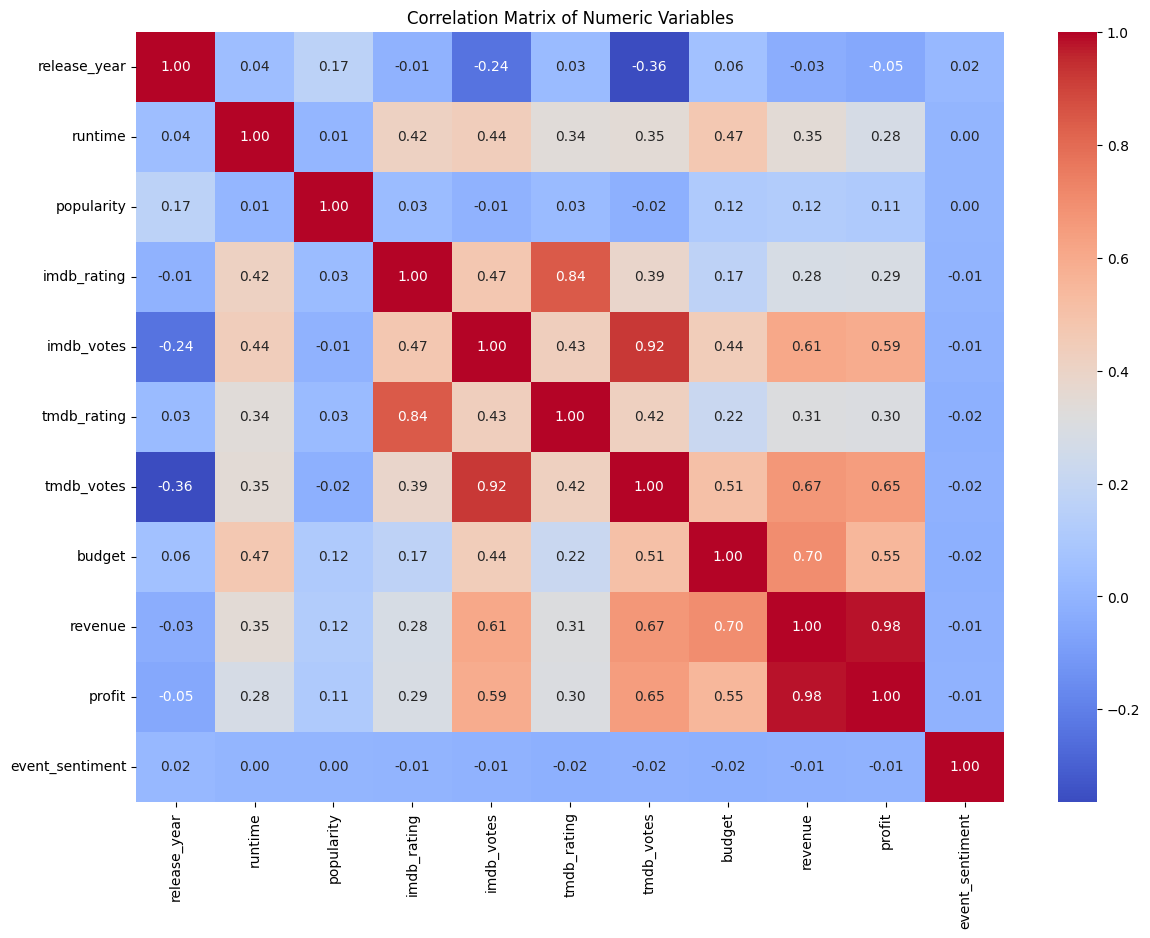

In [7]:
# Filter only the numeric columns from the DataFrame
movies_numeric = movies_encoded.select_dtypes(include=['number'])

# Compute the correlation matrix on numeric columns only
correlation_matrix = movies_numeric.corr()

# Print the correlation matrix
print(correlation_matrix)

# Optional: Visualize the correlation matrix using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Variables")
plt.show()


In [8]:
# Group by 'events' and calculate the average popularity and ratings for each event
events_popularity_ratings = df.groupby('events').agg({
    'popularity': 'mean',
    'imdb_rating': 'mean',
    'tmdb_rating': 'mean'
}).reset_index()

# Sort the result to check which events have higher popularity or ratings
events_popularity_ratings_sorted = events_popularity_ratings.sort_values(by='popularity', ascending=False)

# Display the top events with the highest popularity
print(events_popularity_ratings_sorted.head())

# Optional: Sort by IMDb and TMDB ratings as well
events_sorted_by_imdb = events_popularity_ratings.sort_values(by='imdb_rating', ascending=False)
events_sorted_by_tmdb = events_popularity_ratings.sort_values(by='tmdb_rating', ascending=False)

# Display the top events by IMDb rating and TMDB rating
print("Top events by IMDb rating:")
print(events_sorted_by_imdb.head())

print("Top events by TMDB rating:")
print(events_sorted_by_tmdb.head())


                               events   popularity  imdb_rating  tmdb_rating
161   sexual assault on men is a joke  2054.980000     6.840000     7.160000
75                       dog fighting  1112.222222     6.288889     6.938889
166                            sharks   893.417857     6.632143     6.925000
10                  abandoned animals   419.426515     6.300758     6.892424
83                  end credit scenes   410.192308     6.598190     7.094118
Top events by IMDb rating:
                           events  popularity  imdb_rating  tmdb_rating
235                   sad endings   74.600000     8.200000     8.200000
199               bodies of water   55.500000     7.800000     7.800000
229  needles or syringes are used  207.500000     7.400000     7.800000
3                            BDSM  218.521053     7.331579     7.431579
224                  horses dying   15.475000     7.325000     7.075000
Top events by TMDB rating:
                           events  popularity  imdb_

In [9]:
# Group by 'language' and 'events' and count occurrences of each event per language
events_per_language = df.groupby(['language', 'events']).size().reset_index(name='event_count')

# Sort the events by event_count in descending order for each language
events_per_language_sorted = events_per_language.sort_values(by=['language', 'event_count'], ascending=[True, False])

# Display the most common events per language
print(events_per_language_sorted.head(20))  # Display top 20 events for brevity


     language                    events  event_count
0      Basque              horses dying            3
1      Basque           non-human death            3
2      Basque        shaving or cutting            3
3   Cantonese               car crashes            2
4   Cantonese   car honk / tire screech            2
5   Cantonese                   choking            2
6   Cantonese            falling deaths            2
7   Cantonese              gun violence            2
8   Cantonese                kidnapping            2
9   Cantonese      major character dies            2
10  Cantonese             onscreen rape            2
11  Cantonese           planes crashing            2
12  Cantonese                restraints            2
13  Cantonese            sexual content            2
14  Cantonese    sexual objectification            2
15  Cantonese                  stalking            2
16  Cantonese                   torture            2
17  Cantonese               unconscious       

In [10]:
# Calculate the average IMDb rating per language
avg_imdb_ratings = df.groupby('language')['imdb_rating'].mean().reset_index()

# Sort the languages by average IMDb rating in descending order
avg_imdb_ratings_sorted = avg_imdb_ratings.sort_values(by='imdb_rating', ascending=False)

# Display the languages with higher average IMDb ratings
print(avg_imdb_ratings_sorted.head(10))  # Display top 10 languages with higher ratings


      language  imdb_rating
25     Turkish     8.200000
14     Latvian     8.000000
4        Czech     7.835135
12    Japanese     7.498726
16      Polish     7.480000
17  Portuguese     7.300000
23       Tamil     7.200000
5       Danish     7.187332
10       Hindi     7.086379
20     Spanish     7.039222


Sentiment Distribution by Language
Goal: Understand how sentiment varies across different languages.
Approach: Group the data by language and calculate the average sentiment score for each language. You can then analyze the languages with the most positive or negative sentiments.

In [11]:
avg_sentiment_by_language = df.groupby('language')['event_sentiment'].mean().reset_index()
avg_sentiment_by_language_sorted = avg_sentiment_by_language.sort_values(by='event_sentiment', ascending=False)
print(avg_sentiment_by_language_sorted.head())


     language  event_sentiment
1   Cantonese         0.097656
19     Slovak         0.046667
21    Swedish         0.005619
3     Chinese         0.000071
16     Polish         0.000000


 Sentiment by Genre
Goal: Determine if certain genres have more positive or negative sentiments.
Approach: Group the data by genres and calculate the average sentiment for each genre. You could also check how sentiment changes over time for each genre.

In [12]:
avg_sentiment_by_genre = df.groupby('genres')['event_sentiment'].mean().reset_index()
avg_sentiment_by_genre_sorted = avg_sentiment_by_genre.sort_values(by='event_sentiment', ascending=False)
print(avg_sentiment_by_genre_sorted.head())


          genres  event_sentiment
5    documentary         0.010417
31       romance        -0.002249
30       mystery        -0.009113
21        comedy        -0.009679
13       romance        -0.010427


Sentiment Over Time
Goal: Track sentiment trends over the years and see if it is improving or declining.
Approach: Group the data by release year and calculate the average sentiment for each year.

In [13]:
avg_sentiment_by_year = df.groupby('release_year')['event_sentiment'].mean().reset_index()
avg_sentiment_by_year_sorted = avg_sentiment_by_year.sort_values(by='release_year')
print(avg_sentiment_by_year_sorted.head())


   release_year  event_sentiment
0          2019        -0.026416
1          2020        -0.030225
2          2021        -0.031363
3          2022        -0.023120
4          2023        -0.024065


Correlation Between Sentiment and Popularity/Ratings
Goal: Investigate if there is a correlation between event sentiment and movie popularity/ratings.
Approach: Calculate the correlation between event_sentiment, popularity, and ratings (imdb_rating, tmdb_rating).

In [14]:
correlation = df[['event_sentiment', 'popularity', 'imdb_rating', 'tmdb_rating']].corr()
print(correlation)


                 event_sentiment  popularity  imdb_rating  tmdb_rating
event_sentiment         1.000000    0.003000    -0.006071    -0.018000
popularity              0.003000    1.000000     0.031441     0.028739
imdb_rating            -0.006071    0.031441     1.000000     0.841312
tmdb_rating            -0.018000    0.028739     0.841312     1.000000


 Popularity vs. Genre Sentiment
Goal: See if more popular genres tend to have higher or lower sentiment scores.
Approach: Group by genre and calculate the average popularity and average sentiment for each genre.

In [15]:
genre_popularity_sentiment = df.groupby('genres').agg({
    'popularity': 'mean',
    'event_sentiment': 'mean'
}).reset_index()
genre_popularity_sentiment_sorted = genre_popularity_sentiment.sort_values(by='popularity', ascending=False)
print(genre_popularity_sentiment_sorted.head())


              genres  popularity  event_sentiment
14   science fiction  420.787672        -0.024745
1          adventure  326.072435        -0.029544
18            action  314.378056        -0.020578
20         animation  279.249355        -0.037587
7             family  251.425508        -0.039510


Sentiment for Events
Goal: See if certain types of events have a strong positive or negative sentiment.
Approach: Group by event type and calculate the average sentiment score for each event type.

In [16]:
avg_sentiment_by_event = df.groupby('events')['event_sentiment'].mean().reset_index()
avg_sentiment_by_event_sorted = avg_sentiment_by_event.sort_values(by='event_sentiment', ascending=False)
print(avg_sentiment_by_event_sorted.head())


                               events  event_sentiment
237                    sexual content              0.5
161   sexual assault on men is a joke              0.5
162                    sexual content              0.5
163            sexual objectification              0.5
160                    sexual assault              0.5


Sentiment Across Different Rating Platforms (IMDB vs. TMDB)
Goal: Compare how sentiment correlates with ratings from different platforms (IMDB and TMDB).
Approach: Calculate the correlation between event_sentiment, imdb_rating, and tmdb_rating.

In [17]:
sentiment_vs_ratings = df[['event_sentiment', 'imdb_rating', 'tmdb_rating']].corr()
print(sentiment_vs_ratings)


                 event_sentiment  imdb_rating  tmdb_rating
event_sentiment         1.000000    -0.006071    -0.018000
imdb_rating            -0.006071     1.000000     0.841312
tmdb_rating            -0.018000     0.841312     1.000000


Profitability vs. Sentiment
Goal: Explore how event sentiment correlates with a movie’s profitability (profit = revenue - budget).
Approach: Calculate the correlation between event_sentiment and the profit column.
python



In [18]:
df['profit'] = df['revenue'] - df['budget']
sentiment_vs_profit = df[['event_sentiment', 'profit']].corr()
print(sentiment_vs_profit)


                 event_sentiment    profit
event_sentiment         1.000000 -0.008796
profit                 -0.008796  1.000000


Sentiment by Director
Goal: Explore if certain directors tend to create movies with more positive or negative sentiment.
Approach: Group the data by director and calculate the average sentiment for each director.

In [19]:
avg_sentiment_by_director = df.groupby('director')['event_sentiment'].mean().reset_index()
avg_sentiment_by_director_sorted = avg_sentiment_by_director.sort_values(by='event_sentiment', ascending=False)
print(avg_sentiment_by_director_sorted.head())


              director  event_sentiment
67      Brian De Palma         0.500000
493     Ry Russo-Young         0.500000
407        Neil Burger         0.375000
536  Steven Soderbergh         0.250000
107  Christopher Zalla         0.177083


Sentiment Distribution
Goal: Understand the overall distribution of sentiment scores (e.g., do most events have neutral sentiment, or are they generally positive or negative?).
Approach: Plot a histogram of event_sentiment to visualize its distribution.

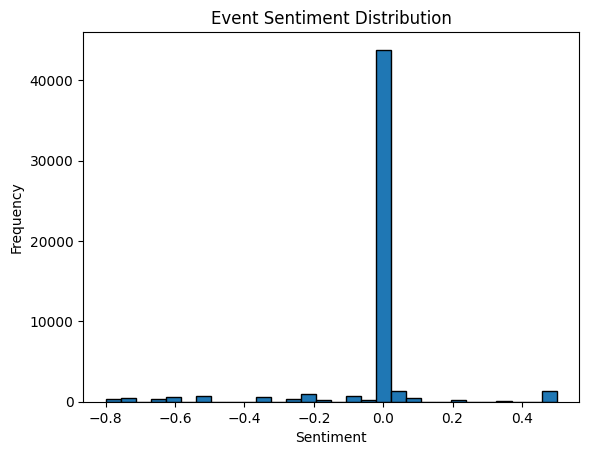

In [20]:
import matplotlib.pyplot as plt

# Plot histogram of event sentiment
plt.hist(df['event_sentiment'], bins=30, edgecolor='black')
plt.title('Event Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()


Comparing Sentiment Across Popular and Less Popular Movies
Goal: See if more popular movies (based on popularity) tend to have higher or lower sentiment.
Approach: Create two groups: high popularity (e.g., popularity > 50) and low popularity (e.g., popularity <= 50). Compare their average sentiments.

In [21]:
high_popularity = df[df['popularity'] > 50]
low_popularity = df[df['popularity'] <= 50]

avg_sentiment_high_pop = high_popularity['event_sentiment'].mean()
avg_sentiment_low_pop = low_popularity['event_sentiment'].mean()

print(f"Average sentiment for high popularity movies: {avg_sentiment_high_pop}")
print(f"Average sentiment for low popularity movies: {avg_sentiment_low_pop}")


Average sentiment for high popularity movies: -0.025622726402450696
Average sentiment for low popularity movies: -0.023645161097029726


Summary of Useful Calculations:
Sentiment by language: Understand which languages tend to have more positive or negative sentiments.
Sentiment by genre: See if certain genres are associated with specific sentiment scores.
Sentiment trends over time: Track changes in sentiment over the years.
Sentiment vs. ratings: Explore how sentiment correlates with IMDB, TMDB ratings, and popularity.
Sentiment by director: Find out if certain directors consistently make movies with a specific sentiment.
Profitability vs. sentiment: Investigate the relationship between sentiment and a movie’s profitability.
These calculations will help you identify patterns in the data and might also provide valuable insights to refine your sentiment analysis. You can further analyze the correlations to spot trends that could drive recommendations or predictions based on sentiment.

Check which languages have the higher amount of events
We can group the data by language and count the number of occurrences of events for each language. This will allow us to see which languages are associated with more events.

In [22]:
# Count the number of events per language
event_count_by_language = df.groupby('language')['events'].count().reset_index()
event_count_by_language_sorted = event_count_by_language.sort_values(by='events', ascending=False)

# Display the results
print(event_count_by_language_sorted.head())


   language  events
6   English   46023
8    French    2242
13   Korean     801
20  Spanish     668
5    Danish     371


Check if there's any correlation between high ratings and certain types of events
We'll calculate the correlation between event sentiment (or other metrics like imdb_rating, tmdb_rating) and different event types. This could help us identify if certain types of events (e.g., "flashing lights" or "blood or gore") are linked to higher ratings or popularity.

We can look at the correlation between event types and ratings by using the following steps:

a. Encode the events into a numeric format, so we can calculate correlations.
We need to create dummy variables for the events column, turning each event type into a separate binary column (i.e., 1 if the event occurred, 0 if it did not).

b. Then calculate the correlation between the encoded event types and ratings.

In [23]:
# Create dummy variables for the events column (one-hot encoding)
events_encoded = pd.get_dummies(df['events'])

# Add the ratings (IMDB and TMDB) to the encoded DataFrame
events_with_ratings = pd.concat([events_encoded, df['imdb_rating'], df['tmdb_rating']], axis=1)

# Calculate the correlation matrix
correlation_matrix = events_with_ratings.corr()

# Display the correlation matrix
print(correlation_matrix)


                               9/11   ABA therapy   Achilles Tendon injury  \
 9/11                      1.000000     -0.000038                -0.000159   
 ABA therapy              -0.000038      1.000000                -0.000159   
 Achilles Tendon injury   -0.000159     -0.000159                 1.000000   
 BDSM                     -0.000117     -0.000117                -0.000490   
 D.I.D. misrepresentation -0.000097     -0.000097                -0.000406   
...                             ...           ...                      ...   
spitting                  -0.000196     -0.000196                -0.000819   
torture                   -0.000097     -0.000097                -0.000406   
vomiting                  -0.000123     -0.000123                -0.000516   
imdb_rating               -0.011260     -0.021869                -0.012952   
tmdb_rating               -0.011993     -0.012875                -0.007894   

                               BDSM   D.I.D. misrepresentation 

This will give us a correlation matrix showing how different event types are correlated with the IMDB and TMDB ratings. Higher positive correlations would indicate that certain types of events are more likely to appear in higher-rated movies.

Analysis:
If you see strong correlations between event types (e.g., "car crashes" or "blood or gore") and high ratings, you can investigate further whether those types of events are popular in blockbuster movies.
If certain event types have negative correlations with ratings, it might suggest that those events are not typically associated with highly rated movies.